Mariel Vicente

D213: Advanced Data Analytics

<center> 

## Performance Assessment: Task 2

</center>


### Part I: Research Question
My research question for this performance assessment is, “Can the sentiment of a customer's review be determined using sentiment analysis?” The goal of this analysis is to build a neural network model using natural language processing (NLP) techniques to accurately identify customer sentiments based on text reviews. This includes cleaning the data set by removing unwanted characters and words, performing tokenization and lemmatization, splitting the data into training and testing sets, and padding the sequences to improve model efficiency. I will explore different model parameters such as early stopping to determine the best fit. The model will be evaluated using accuracy and loss metrics to answer my research question. A recurrent neural network (RNN) is capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.

### Part II: Data Preparation
I began the data cleaning process by importing all three text files and concatenating them. I explored the data using the shape, info, head, and describe functions. I assessed the data for nulls and NaNs and none were found. I then calculated and plotted the number of positive vs. negative sentiments.

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import string
import re
from pandas import Series, DataFrame

#Data visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split #split into train/test sets

#Natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#TensorFlow
import tensorflow as tf
import keras
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from keras.callbacks import EarlyStopping

In [2]:
#Import all three files
amazon = pd.read_csv('C:/Users/12034/OneDrive/Documents/WGU/amazon_cells_labelled.txt', sep='\t', header=None, names=['review','sentiment'])
imdb = pd.read_csv('C:/Users/12034/OneDrive/Documents/WGU/imdb_labelled.txt', sep='\t', header=None, names=['review','sentiment'])
yelp = pd.read_csv('C:/Users/12034/OneDrive/Documents/WGU/yelp_labelled.txt', sep='\t', header=None, names=['review','sentiment'])

#Concatenate the files together
df = pd.concat((amazon, imdb, yelp), ignore_index=True)

In [3]:
#Explore the data
df.shape

(2748, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2748 non-null   object
 1   sentiment  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [5]:
df.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [6]:
df.describe()

,sentiment
count,2748.000000
mean,0.504367
std,0.500072
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
#Assess for nulls
df.isnull().any()

review       False
sentiment    False
dtype: bool

In [8]:
#Assess for NaNs
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
#Calculate number of positive and negative sentiments
df.sentiment.value_counts()

sentiment
1    1386
0    1362
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

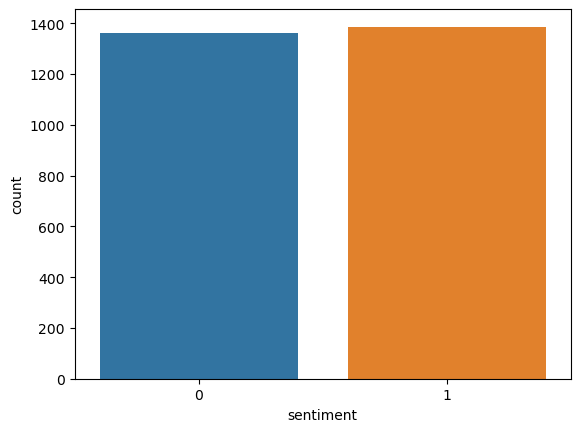

In [10]:
#Plot distribution of sentiments
sns.countplot(x='sentiment', data=df)

Next, I used regular expression to substitute any unusual characters that were not letters in the alphabet with a space. I also converted all letters to lowercase. These are done to clean the text and improve model performance by making the data easier for the model to process. I performed tokenization using the word_tokenize function from the natural language toolkit (nltk). Tokenization is the process of breaking down text into smaller units called tokens. In this instance, we are breaking down sentences into individual words. This transforms the text so that our algorithm can process and utilize it. I removed the stop words from the text and performed lemmatization, which is the process of reducing words to their base form.

In [11]:
description_list = []
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

for description in df['review']:
    #Regular expression, removes punctuations and special characters
    description = re.sub(r"[^a-zA-Z]", " ", description)
    #Convert to lowercase
    description = description.lower()
    #Perform tokenization
    words = word_tokenize(description)
    #Remove stop words and perform lemmatization
    description = [lemma.lemmatize(word) for word in words if word not in stop_words]
    description = " ".join(description)
    #Append the cleaned description to the list
    description_list.append(description)

In order to determine the vocabulary size, I used the Tokenizer package to map each unique word in the review column to a unique integer index using the fit_on_texts and word_index functions. I then calculated the number of unique integers, and the vocabulary size was measured as 5272.

In [12]:
#Identify vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  5272


I determined the minimum, median, and maximum lengths of the sequences using the NumPy package. The max was measured as 1393. This felt high for padding purposes, so I chose to calculate the maximum length in the 95th percentile. This ensures that 95% of reviews have a length that falls within the min to max range while minimizing excessive padding. The maximum length was measured to be 26. To determine the word embedding length, I calculated the fourth root of the vocabulary size, which was measured to be 9. This calculation method is considered a general shortcut that can provide a starting point for model experimentation.

In [13]:
#Determine min, med, and max lengths of reviews
review_length = []
for char_len in df['review']:
    review_length.append(len(char_len.split(" ")))

review_min = np.min(review_length)
review_med = np.median(review_length)
review_max = np.max(review_length)
print("Minimum length of sequences is: ", review_min)
print("Median length of sequences is: ", review_med)
print("Maximum length of sequences is: ", review_max)

Minimum length of sequences is:  1
Median length of sequences is:  11.0
Maximum length of sequences is:  1393


In [14]:
#Determine max in the 95th percentile
max_length = int(np.percentile(review_length, 95))
print(max_length)

26


In [15]:
#Determine word embedding length
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print(max_sequence_embedding)

9


I split the data 80/20 into training and test sets. The training size was 2198 and the testing size was 550. I then applied padding to x_train and x_test using the pad_sequences function. Padding is the process of adding zeroes to sequences so that each sequence in the data set has the same length. I set the padding parameters to 'padding=post', which adds the zeroes to the end of the sequence, and 'truncating=post', which truncates the end of any sequences that are longer than my chosen maximum sequence length of 26. Since y_train & y_test are single values, they did not need to be padded. Padding the sequences maintains uniformity for the neural network model. See below for single padded sequence. Once both sets were padded, I exported the sets to csv files and converted each to a numpy array for use in the model.

In [16]:
#Split the data into training and test sets
X = np.array(description_list)
Y = df.sentiment.values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

#View training and testing sample sizes
print("Training Size: ", x_train.shape)
print("Testing Size: ", x_test.shape)

Training Size:  (2198,)
Testing Size:  (550,)


In [17]:
#Apply padding to training set
sequences_train = tokenizer.texts_to_sequences(x_train)
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')

#Apply padding to test set
sequences_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

#Display single padded sequence
print(padded_train[0])

[ 165 2104 4370 1920 4369 2098 2105 1656  208   53  685  203   89 2018
  208 4370  378 2106 2107 1195    0    0    0    0    0    0]


In [18]:
#Export data to csv
pd.DataFrame(padded_train).to_csv('C:/Users/12034/OneDrive/Documents/WGU/D213_T2_MV_padded_train.csv')
pd.DataFrame(y_train).to_csv('C:/Users/12034/OneDrive/Documents/WGU/D213_T2_MV_y_train.csv')
pd.DataFrame(padded_test).to_csv('C:/Users/12034/OneDrive/Documents/WGU/D213_T2_MV_padded_test.csv')
pd.DataFrame(y_test).to_csv('C:/Users/12034/OneDrive/Documents/WGU/D213_T2_MV_y_test.csv')

print(len(padded_train))
print(len(y_train))
print(len(padded_test))
print(len(y_test))

2198
2198
550
550


In [19]:
#Convert padded data to numpy array to be used in model
training_padded = np.array(padded_train)
training_label = np.array(y_train)
test_padded = np.array(padded_test)
test_label = np.array(y_test)

My neural network model contains five layers. The first layer of my model is an embedding layer using the Embedding package, which converts word indices into dense vectors. The GlobalAveragePooling1D layer reduces dimensionality by calculating the average accross all steps in the sequence. Next are two dense layers with 100 and 50 nodes, using the ReLU activation function, which are hidden layers that process that features of the input data. Last is the output dense layer with 1 node, using the sigmoid activation function for binary classification. 

The loss function used for the model was binary crossentropy, which is appropriate for our model since we have two categories of sentiment (0/1, positive and negative). The optimizer used was adam, which is standard for binary classification. Training was set to a maximum of 20 epochs, which was subject to the stopping criteria. The EarlyStopping function was used to prevent overfitting by stopping training if there is no improvement in the validation loss for two consecutive epochs (patience=2). The evaluation metric used during training was accuracy.  The total number of parameters for the model was 273,801. 

See below for output of the model summary and final training epoch. 

In [20]:
#Build the NN model
activation = 'sigmoid' #transforms output from one layer to another
loss = 'binary_crossentropy' #tracks loss percentage
optimizer = 'adam'
num_epochs = 20

#Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation=activation)
])

#Build the model explicitly, then fit the model and obtain output summary
model.build(input_shape=(None, max_length))
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()
history = model.fit(training_padded, training_label, batch_size=32, epochs=num_epochs,
                    validation_split = 0.2, callbacks=[early_stopping_monitor], verbose=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 50)         │       263,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,801 (1.04 MB)

 Trainable params: 273,801 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4833 - loss: 0.6936 - val_accuracy: 0.5205 - val_loss: 0.6921
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5354 - loss: 0.6902 - val_accuracy: 0.5659 - val_loss: 0.6738
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7152 - loss: 0.6402 - val_accuracy: 0.7705 - val_loss: 0.5454
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8752 - loss: 0.3970 - val_accuracy: 0.7955 - val_loss: 0.4441
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8964 - loss: 0.2721 - val_accuracy: 0.8000 - val_loss: 0.4252
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9215 - loss: 0.2037 - val_accuracy: 0.8045 - val_loss: 0.4307
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9575 - loss: 0.1316 - val_accuracy: 0.8114 - val_loss: 0.4341


### Part IV: Model Evaluation

While the number of epochs was set to a maximum of 20 epochs, the stopping criteria stopped the model at 7 epochs to prevent overfitting. This suggests that 7 is the optimal number of epochs for our model.

Below I evaluated the accuracy and loss of the model based on the training and testing set. For the testing set, the loss was calculated as 0.47 and the accuracy was 0.80. This suggests that the model was able to accuractly predict the sentiment of the test data 80% of the time, which is acceptable. 

Next I plotted the model's training process, comparing the accuracy to validation accuracy and loss to validation loss for each epoch. Both plots show the training metrics performing well while the validation metrics level off, which indicates overfitting. 

In [21]:
#Verify model accuracy on training data
results = model.evaluate(training_padded, training_label, verbose=0)
print('Training Loss: ', results[0])
print('Training Accuracy: ', results[1])

Training Loss:  0.17274218797683716
Training Accuracy:  0.9363057613372803


In [22]:
#Verify model accuracy on unseen test data
results = model.evaluate(test_padded, test_label, verbose=0)
print('Test Loss: ', results[0])
print('Test Accuracy: ', results[1])

Test Loss:  0.47626253962516785
Test Accuracy:  0.800000011920929


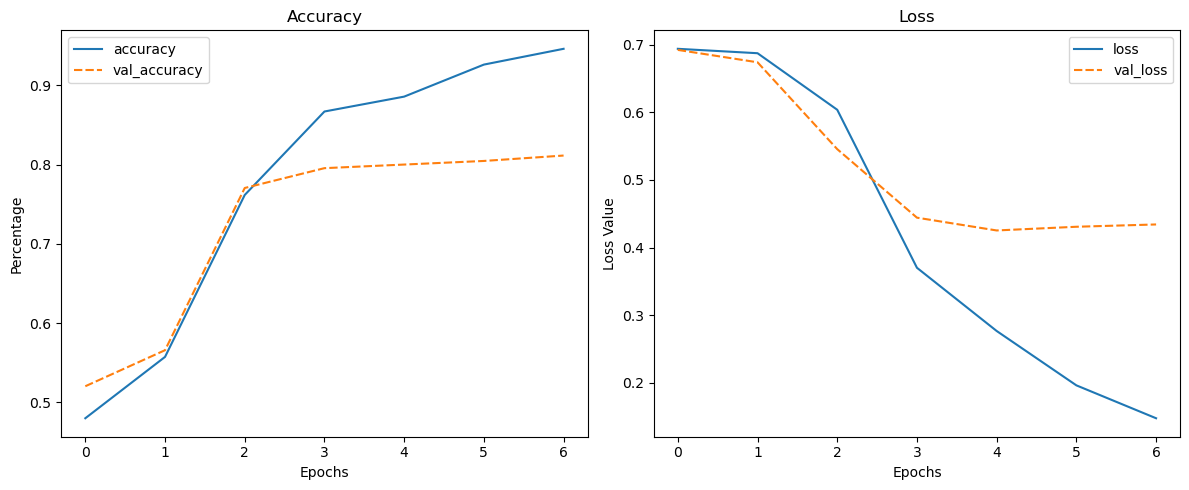

In [23]:
#Plot Accuracy & Loss plots

df_history = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=df_history[['accuracy', 'val_accuracy']], ax=axes[0])
sns.lineplot(data=df_history[['loss', 'val_loss']], ax=axes[1])
axes[0].set_title('Accuracy')
axes[1].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[1].set_xlabel('Epochs')
axes[0].set_ylabel('Percentage')
axes[1].set_ylabel('Loss Value')
plt.tight_layout()
plt.show()

In [24]:
#Save the model
model.save('C:/Users/12034/OneDrive/Documents/WGU/nn_model.keras')

### Part V: Summary and Recommendations

While the predictive accuracy of the model based on the testing set was measured to be 79%, the accuracy and loss plots showed signs of overfitting. This means that the model is learning the training data too well and is starting to capture random noise rather than patterns in the input data. I recommend addressing the overfitting by experimenting further with early stopping and other related techniques such as dropout.

### Part VI: Reporting

#### Sources for Third-Party Code
Elleh, Festus. D213 Task 2 Cohort Webinar PPT. Retrieved December 23, 2024.


#### Sources

Elleh, Festus. D213 Task 2 Cohort Webinar PPT. Retrieved December 23, 2024.

Kotzias, D. (2015). Sentiment Labelled Sentences (Dataset). UCI Machine Learning Repository. https://doi.org/10.24432/C5